# Classification (2) – implementation and application of Nearest Neighbour classification, and Logistic Regression

## Introduction

In this notebook we continue on with some of methods of 
classification, starting with an implementation of Naive Bayes, then an application of Naive Bayes on a benchmark dataset. The notebook also looks into the related method of Logistic Regression for comparison.

$$
\newcommand{\dprod}[2]{{\langle #1, #2 \rangle}}
\newcommand{\argmax} [1] {{\underset{#1}{\mathrm{argmax}~}}}
\newcommand{\argmin} [1] {{\underset{#1}{\mathrm{argmin}~}}}
\renewcommand{\min} [1] {{\underset{#1}{\mathrm{min}~}}}
\renewcommand{\v}[1]{\mathbf{#1}}
$$

In [1]:
%pylab inline
%load_ext autoreload
%autoreload
import numpy as np
import matplotlib.pyplot as pl
import util

from scipy.stats import itemfreq
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal as mvnorm

import sklearn
import scipy
import matplotlib
print("SKLEARN",sklearn.__version__)
print ("SCIPY",scipy.version.full_version)
print("NUMPY",np.__version__)
print("MATPLOTLIB",matplotlib.__version__)

X, Y = util.load_data() # passenger_class, is_female, sibsp, parch, fare, embarked (categorical 0-3)
X_demean = X - np.mean(X, axis=0)
X_unitsd = X_demean/(np.std(X_demean,axis=0))
X_whiten = np.dot(X_demean, util.whitening_matrix(X_demean))


Populating the interactive namespace from numpy and matplotlib
version 1
SKLEARN 0.21.3
SCIPY 1.3.1
NUMPY 1.17.0
MATPLOTLIB 3.1.1


In [14]:
import sys
sys.version

'3.7.5 (default, Nov  1 2019, 02:16:23) \n[Clang 11.0.0 (clang-1100.0.33.8)]'

## Classification
Classification models learn a mapping $h(\boldsymbol{X})$ from a feature space $\boldsymbol{X}$ to a finite set of labels $\boldsymbol{Y}$

In this lab we will focus for simplicity on binary classification, where the labels are assumed to be in $\{-1,1\}$ or alternatively $\{0,1\}$. 


We will use simple generated datasets and a real data set on the sinking of the Titanic to explore some different classification algorithms. For a description of the variables and more information on the data see: https://www.kaggle.com/c/titanic-gettingStarted/data

One approach to learning a classification function $h(\boldsymbol{X})$ is to model $P(y|\boldsymbol{x})$ and convert that to a classification by setting:
\begin{equation}h(\boldsymbol{X}) = \begin{cases} 1 & \text{if }P(y|\boldsymbol{x}) > \frac{1}{2}\\ 0 & \text{otherwise}\end{cases}
\end{equation}


Example: Suppose we want to build a model to predict the probability of survival on the Titanic based on just two categorical features, a persons class (1,2 or 3) and their sex (1=female,0=male). An obvious approach would be to create a category for each combination of our features (female 1st, female 2nd ... male 3rd) and calculate the proportion who survived in each as an estimate for the survival probability $P(y|\boldsymbol{x})$. For each observation in our test data - we simply look up the survival rate in the corresponding category.

This corresponds to maximum likelihood estimation: $\hat{\theta} = argmax_{\theta'}P(data|\theta')$, where the parameters, $\theta$, we want to estimate are the true probabilities $P(y|\boldsymbol{x})$ for each combination of $\boldsymbol{x}$ and $data$ is the set features and labels we have observed.

In [2]:
combinations = [(i,j) for i in [1,2,3] for j in [0,1]]
for c in combinations:
    match = np.where((X[:,0] == c[0]) * (X[:,1] == c[1]))[0]
    print(c,sum(Y[match])/float(len(match)))

(1, 0) 0.38961038961038963
(1, 1) 0.9846153846153847
(2, 0) 0.1780821917808219
(2, 1) 0.9122807017543859
(3, 0) 0.14218009478672985
(3, 1) 0.4583333333333333


**Question:** *Why will this approach not work in general? What happens as we increase the number of features or the number of values each feature can take? What about if features are continuous?*

## Naive Bayes


Following Bayes Rule, we can write:

$P(y|\boldsymbol{x}) \propto P(y)P(\boldsymbol{x}|y) = P(y)P(x_1,x_2...x_D|y) $

It easy to estimate $P(y)$ as just the proportions of each class in the training data. We could also directly estimate $P(x_1,x_2...x_D|y)$ for each $y$ (for example with kernel density estimation) but as the number of features $D$ gets large this estimation suffers the curse of dimensionality.

Naive Bayes assumes that the data was generated by a model where all the features are independent of one-another given the class label so that we can estimate $P(x_j|y)$ separately for each feature.

\begin{equation}
P(y|\boldsymbol{x}) \propto P(y)\prod_{j=1}^D P(x_j|y)
\end{equation}

The normalisation constant can be obtained;

\begin{equation}
P(y|\boldsymbol{x}) = \frac{P(y)\prod_{j=1}^D P(x_j|y)}{P(\boldsymbol{x})},
\end{equation}
where,
\begin{equation}
P(\boldsymbol{x}) = P(y=0)\prod_{j=1}^D P(x_j|y=0) + P(y=1)\prod_{j=1}^D P(x_j|y=1),
\end{equation}
this operation is called [marginalisation](http://en.wikipedia.org/wiki/Marginal_distribution), since we marginalise (or sum/integrate out) $y$ from the joint distribution (top line) $P(y, \mathbf{x}) = P(y)P(\mathbf{x}|y)$ to obtain a distribution over $\mathbf{x}$.

**Exercise:** *Implement a Naive Bayes model for the Titanic data set using passenger_class and is_female as features*

In [3]:
# a function that may be useful
def proportions(array):
    """ returns a map from each unique value in the input array to the proportion of times that value occures """
    prop = itemfreq(array)
    prop_unique = np.unique(array,return_counts=True)
    # print("Here is prop:")
    print(prop_unique)
    prop[:,1] = prop[:,1]/sum(prop,axis=0)[1]
    return dict(prop)

class Naive_Bayes:
    def train(self,X,Y):
        """ trains the model with features X and labels Y """
        # 1) Estimate P(Y=1)
        self.py = sum(Y)/float(len(Y))

        # 2) For each feature, x, estimate P(x|y=1) and P(x|y=0)
        survived = X[np.where(Y==1)[0],:] # the features of those who survived
        died  = X[np.where(Y==0)[0],:] # the features for those who died

        # estimate P(gender|survived) - return a map from gender value to probability
        self.gs = proportions(survived[:,1])

        # estimate P(class|survived) - return a map from class to probability
        self.cs = proportions(survived[:,0]) 

        # estimate P(gender|died)-return a map from gender value to probability
        self.gd = proportions(died[:,1])

        # estimate P(class|died) - return a map from class to probability
        self.cd = proportions(died[:,0])
    
    def predict(self,sex,p_class):
        """ outputs the probability of survival for a given class and gender """
        # caclulate unormalized P(y = 1|sex,p_class) as P(y=1)P(sex|y=1)P(p_class|y=1) 
        ps = self.py*self.gs[sex]*self.cs[p_class]

        # calculate unormalized P(y = 0|sex,p_class) as P(y=0)P(sex|y=0)P(p_class|y=0)
        pd = (1-self.py)*self.gd[sex]*self.cd[p_class]

        # calculates the survival ratio as ps/pd and the normalized probability  from the ratio
        r = ps/pd
        psn = r/(1+r)
        # Or alternatively: psn = ps / (ps + pd) 
        return psn

# run the model
model = Naive_Bayes()
model.train(X,Y)
for p_class,sex in combinations:
    print((p_class,sex),model.predict(sex,p_class))



(array([0., 1.]), array([ 73, 160]))
(array([1., 2., 3.]), array([94, 65, 74]))
(array([0., 1.]), array([288,  58]))
(array([1., 2., 3.]), array([ 48,  65, 233]))
(1, 0) 0.4243339521922548
(1, 1) 0.8891634908224024
(2, 0) 0.2734674433208462
(2, 1) 0.8037866248511775
(3, 0) 0.10677887360860094
(3, 1) 0.5654123815352137


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  after removing the cwd from sys.path.


**Exercise:** *Compare these predictions with those just based on the proportion of survivals. How true is the Naive Bayes assumption for this case?*

**Question:** *How does the number of parameters to be learnt scale with the number of features for Naive Bayes?*

**Exercise:** *Run Naive Bayes from Sci-Kit Learn using the same features*

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB

# Sklearn doesn't have a model that expects categorical data. 
# We need to first encode our (p_class, sex) to (is_first,is_second,is_third,is_female,is_male)

# use preprocessing.OneHotEncoder to create a new dataset X2 that is the transformation of the first 2 columns of X

nb_enc = OneHotEncoder()
X2 = nb_enc.fit(X[:,0:2]).transform(X[:,0:2]).toarray()

# fit a Multinommial Naive Bayes Model

nb = MultinomialNB()
nb.fit(X2,Y)

# transforms our combinations to the one-hot encoding
c = nb_enc.transform(np.asarray(combinations)).toarray()

# gets predictions for each combination
predictions = nb.predict_proba(c)

# prints your predictions in the same format as previous models
for i in range(len(c)):
    print(combinations[i],predictions[i][1])


(1, 0) 0.4226630709701513
(1, 1) 0.8863892268829936
(2, 0) 0.27410238327333064
(2, 1) 0.8009625562382566
(3, 0) 0.10796095358725434
(3, 1) 0.5632808975188677


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Naive Bayes can also handle continuous features. The data below is generated by a ```Gaussian mixture model```. For each class there is a separate 2-dimensional Gaussian distribution over the features x1, x2. 



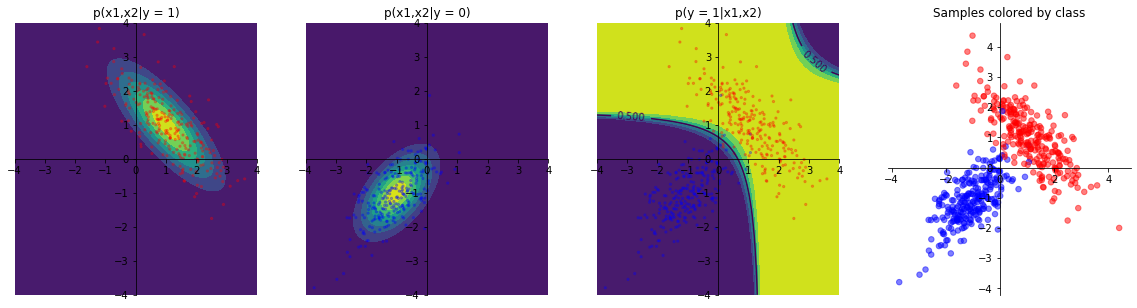

In [5]:
# Generates some data from a Gaussian Mixture Model. 
mean0 = [-1,-1]  # the mean of the gaussian for class 0      
mean1 = [1,1] # the mean of the gaussian for class 1
cov0 = [[.5, .28], [.28, .5]] # the covariance matrix for class 0
cov1 = [[1, -.8], [-.8, 1]] # the covariance matrix for class 1
mixture = util.GaussianMixture(mean0,cov0,mean1,cov1)
mX,mY = mixture.sample(500,0.5,plot=True)


**Exercise:** *Fit a Gaussian Naive Bayes model using Sklearn*

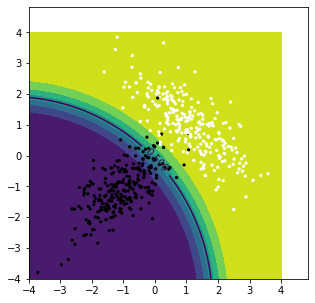

In [6]:
from sklearn.naive_bayes import GaussianNB

# fit a GaussianNB model

gnb = GaussianNB()
gnb.fit(mX,mY)


# plots the probability that a point in x,y belogs to the class Y=1 according to your model and the decision boundary p=.5
x = np.linspace(-4,4,100)
y = np.linspace(-4,4,100)
test_points = np.dstack(np.meshgrid(x, y)).reshape(-1,2)
z = gnb.predict_proba(test_points)[:,1].reshape(len(x),len(y)) # probability Y = 1
f,ax = subplots(1,1,figsize=(5,5))
cn = ax.contourf(x,y,z)
ct = ax.contour(cn,levels=[0.5])
ax.scatter(mX[:,0],mX[:,1],s=5, c = ["black" if t < 1 else "white" for t in mY],alpha=1)
ax.clabel(ct)
show()

# model would be fit perfectly by QDA (doesn't make the same independence assumption as Naive Bayes)

# Try changing the covariance matrices and refitting your model. 
# When does the probability distribution returned by Naive Bayes resemble the true one

## Logistic Regression

Logistic regression models $P(y|\boldsymbol{x})$ directly by assuming it is a (logistic) function of a linear combination of the features. The logistic function $\theta(s) = \frac{e^s}{e^s+1}$ maps the weighted features to $[0,1]$ to allow it to model a probability. Training logistic regression corresponds to learning the weights $\boldsymbol{w}$ to maximise the likelihood function:

\begin{equation}
P(y_1...y_n|\boldsymbol{x}_1...\boldsymbol{x}_n,\boldsymbol{w}) = \prod_{i=1}^n \theta(y_i\boldsymbol{w}^T\boldsymbol{x}_i)
\end{equation}

Maximising the likelihood $P(y_1...y_n|\boldsymbol{x}_1...\boldsymbol{x}_n,\boldsymbol{w})$ is equivalent to minimising the negative log-likelihood: 
\begin{equation}
\boldsymbol{w}^* = argmin_{\boldsymbol{w}}\left( -\log\left(\prod_{i=1}^n \theta(y_i\boldsymbol{w}^T\boldsymbol{x}_i)\right)\right)
= argmin_{\boldsymbol{w}}\left( \sum_{i=1}^n \ln(1+e^{-y_i\boldsymbol{w}^T\boldsymbol{x}_i})\right)
\end{equation}

Once we have the weights $\boldsymbol{w}^*$, we can predict the probability that a new observation belongs to each class.

**Question:** *Suppose that we have a data set that is linearly separable. What happens to the weights $w$ when we run logistic regression?*

**Exercise:** *Use Sklearn to fit a logistic regression model on the Gaussian mixture data.*

In [7]:
#Run Logistic regression on the Gaussian mixture data
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(C = 10000, fit_intercept=False)
logistic.fit(mX,mY)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

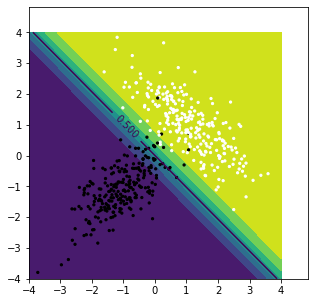

In [8]:
# plot the probability y = 1 as over the feature space as for Naive Bayes
logistz = logistic.predict_proba(test_points)[:,1].reshape(len(x),len(y)) # probability Y = 1
f,ax = subplots(1,1,figsize=(5,5))
cn = ax.contourf(x,y,logistz)
ct = ax.contour(cn,levels=[0.5])
ax.scatter(mX[:,0],mX[:,1],s=5, c = ["black" if t < 1 else "white" for t in mY],alpha=1)
ax.clabel(ct)
show()# implement the jacobian

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


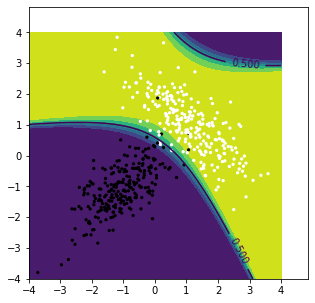

In [9]:
# we can model more complex decision boundaries by expanding the feature space to include combinations of features

# re-fit logistic regression adding in all quadratic combinations of features ie x1,x2,x1x2,x1^2,x2^2
from sklearn.preprocessing import PolynomialFeatures

poly_expand = PolynomialFeatures(2)
m2X = poly_expand.fit(mX).transform(mX)

logistic.fit(m2X,mY)
testpoints2 = poly_expand.transform(test_points)
logistic2z = logistic.predict_proba(testpoints2)[:,1].reshape(len(x),len(y)) # probability Y = 1
f,ax = subplots(1,1,figsize=(5,5))
cn = ax.contourf(x,y,logistic2z)
ct = ax.contour(cn,levels=[0.5])
ax.scatter(mX[:,0],mX[:,1],s=5, c = ["black" if t < 1 else "white" for t in mY],alpha=1)
ax.clabel(ct)
show()

With large numbers of features there is a risk of over fitting to the training data. We can tune a logistic regression model to reduce the risk of over fitting by penalising large weights, $\boldsymbol{w}$ 

**Exersise:** *Experiment with the regularisation parameters sklearn provides: 
penalty = "l1" or "l2" and C = inverse of weight of regularisation term*

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


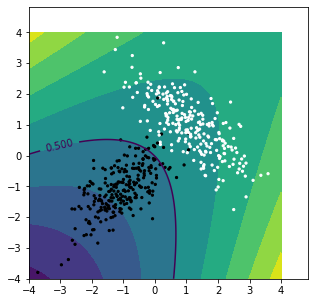

In [10]:
lreg = LogisticRegression(penalty = "l2",C = .0001)
lreg.fit(m2X,mY)

# plots the probability as before
logistic2z_reg = lreg.predict_proba(testpoints2)[:,1].reshape(len(x),len(y)) # probability Y = 1
f,ax = subplots(1,1,figsize=(5,5))
cn = ax.contourf(x,y,logistic2z_reg)
ct = ax.contour(cn,levels=[0.5])
ax.scatter(mX[:,0],mX[:,1],s=5, c = ["black" if t < 1 else "white" for t in mY],alpha=1)
ax.clabel(ct)
show()

In [11]:
# Run logistic regression on the Titanic data

titanic_logist = LogisticRegression()
titanic_logist.fit(X,Y)


# Look at the coefficients (weights) in the model. Are they meaningfull? 
# Do you need to change the way any of the features were encoded?
print(titanic_logist.coef_)
print(titanic_logist.intercept_)

[[-0.86167767  2.46368356 -0.30054043 -0.02526696  0.0037132   0.11749166]]
[0.50953296]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Implement Logistic Regression (Optional)
Recall for logistic regression we are trying to find (assuming we have encoded $Y$ as $\{-1,1\}$)  
\begin{equation}
\boldsymbol{w}^* = argmin_{\boldsymbol{w}}\left( \sum_{i=1}^n \ln(1+e^{-y_i\boldsymbol{w}^T\boldsymbol{x}_i})\right)
\end{equation}

This is a convex optimisation problem in $\boldsymbol{w}$.

We can solve it using gradient decent (or an optimisation library)

**Exercise:** *Implement logistic regression using scipy's optimisation library and run it on the Gaussian mixture data mX,mY.*

In [12]:
# implement logistic regression using scipy's optimization library and run it on the Gaussian model data
from scipy.optimize import minimize

# copy input so our modifications don't effect original data
dataX = mX
dataY = mY

# encode mY as -1,1
dataY[mY==0] = -1

# add a column of all ones to mX to allow us to fit an intercept
dataX = np.hstack((np.ones((mX.shape[0],1)),mX))

# implement the loss function
def loss(w,X,Y):
    wx = np.dot(X,w)
    l_i = np.log(1+np.exp(-Y*wx))
    return sum(l_i)

# start the optimization with randomly guessed weights    
w0 = np.random.random((dataX.shape[1],1)) 

optimal = minimize(loss,w0,args=(dataX,dataY),method="BFGS")    
w = optimal.x
print(w)

# how does this compare with the coefficients you saw using Sklearn? 
# try refitting the sklearn logistic model with a very high value for C (like 10000).


[-2.43924306  4.28757602  4.17543501]


The optimisation method we are using (BFGS) needs to know the jacobian (gradient of the loss function with respect to w). Since we didn't supply it, python is approximating it numerically. We can speed things up by supplying it.

\begin{equation}
L(\boldsymbol{w}) = \sum_{i=1}^n \ln(1+e^{-y_i\boldsymbol{w}^T\boldsymbol{x}_i})  \longleftarrow \text{ loss function}\\
\nabla{L} = [\frac{\partial L}{\partial w_1},\frac{\partial L}{\partial w_2}, ..., \frac{\partial L}{\partial w_D}] \longleftarrow \text{ definition of gradient}\\
\frac{\partial L}{\partial w_j} = -\sum_{i=1}^n x_{ij} \frac{ y_i e^{-y_i\boldsymbol{w}^T\boldsymbol{x}_i}}{1+e^{-y_i\boldsymbol{w}^T\boldsymbol{x}_i}} \longleftarrow \text{ result of taking partial derivative of loss function with respect to weight $j$}\\
\end{equation}

**Exercise:** *repeat the previous exercise but supply the Jacobian to the minimizer*

In [13]:
# implement jacobian

def grad_loss(w,X,Y):
    wx = np.dot(X,w)
    ewx = np.exp(-Y*wx)
    s = -Y*ewx/(1+ewx)
    result = np.dot(s,X)
    return result
    
# start the optimization with randomly guessed weights    
w0 = np.random.random((dataX.shape[1],1)) 

optimal = minimize(loss,w0,args=(dataX,dataY),jac = grad_loss, method="BFGS")    
print(optimal)
w = optimal.x
print(w) 


      fun: 28.018300018434964
 hess_inv: array([[ 0.36962598, -0.3375654 , -0.34105748],
       [-0.3375654 ,  0.49241254,  0.41170276],
       [-0.34105748,  0.41170276,  0.51561698]])
      jac: array([ 3.09272326e-07,  1.44865335e-06, -1.08008850e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 22
     njev: 24
   status: 0
  success: True
        x: array([-2.43924307,  4.28757619,  4.17543499])
[-2.43924307  4.28757619  4.17543499]
